In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms ## Hence torchvision is basically used as it has many datasets and also transform properities
# that can be applied on these datasets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # To use to cuba GPU

In [ ]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='.data/mnist', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to .data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to .data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/mnist/MNIST/raw



In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() # Just use cpu in this case as it is not compatible with gpu
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

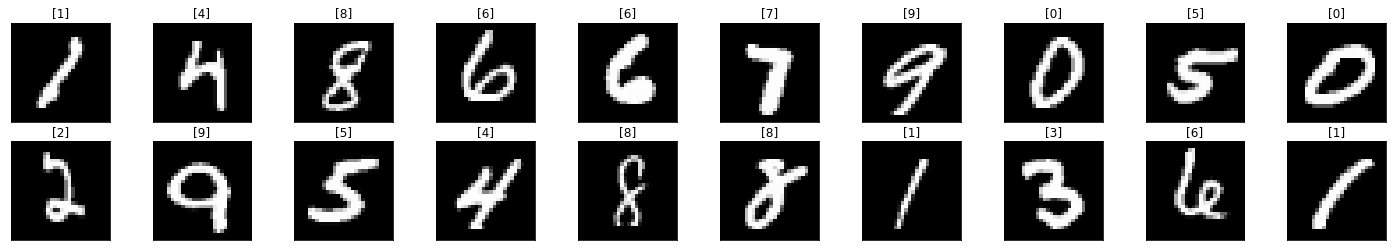

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.__next__()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 20, 5, 1) # Conv layer1
      self.conv2 = nn.Conv2d(20, 50, 5, 1) # Conv layer2
      self.fc1 = nn.Linear(4*4*50, 500)    # Fully connected layer1
      self.dropout1 = nn.Dropout(0.5)   # We use dropout layer between these both FCL as they have the highest number of parameters b/t them
      self.fc2 = nn.Linear(500, 10)   # Fully connected layer2
    def forward(self, x):
      x = F.relu(self.conv1(x))  # Apply ReLu to the feature maps produced after Conv 1 layer
      x = F.max_pool2d(x, 2, 2)  # Pooling layer after Conv 1 layer
      x = F.relu(self.conv2(x))  # Apply ReLu to the feature maps produced after Conv 2 layer
      x = F.max_pool2d(x, 2, 2)  # Pooling layer after Conv 2 layer
      x = x.view(-1, 4*4*50)     # Flattening the output of CNN to feed it into Fully connected layer
      x = F.relu(self.fc1(x))   # Fully connected layer 1 with Relu
      x = self.dropout1(x)     # We use dropout layer between these both FCL as they have the highest number of parameters b/t them
      x = self.fc2(x)         # Fully connected layer 2 with no activation funct as we need raw output from CrossEntropyLoss
      return x

In [ ]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader: # As our train_loader is batch size of 100 and had input images and corresponding labels
    inputs = inputs.to(device)  # Put our inputs and labels in the device as our model is also in the device
    labels = labels.to(device)
    outputs = model(inputs)   # giving input to our model to get corresponding output
    loss = criterion(outputs, labels) # comparing out model's output to original labels
    
    optimizer.zero_grad()  ##sets the initial gradient to zero
    loss.backward()  ## The whole calculated loss is then back propogated to the model
    optimizer.step()  ## Then the weights are updated by doing their derivative w.r.t the Loss
    
    _, preds = torch.max(outputs, 1) # Then we select the max value of raw output and consider it as our prediction. We select it from 10 o/ps
    running_loss += loss.item()  # total loss of 1 epoch
    running_corrects += torch.sum(preds == labels.data) #total accuracy of 1 epoch

  else:
    with torch.no_grad(): # This we done to set no gradient as we do not need it for val as our model is already trained.
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)  # Put our val_inputs and labels in the device as our model is also in the device
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.5762, acc 84.4417 
validation loss: 0.1846, validation acc 94.5900 
epoch : 2
training loss: 0.1493, acc 95.5850 
validation loss: 0.1045, validation acc 96.9400 
epoch : 3
training loss: 0.0981, acc 97.0367 
validation loss: 0.0760, validation acc 97.9200 
epoch : 4
training loss: 0.0748, acc 97.7967 
validation loss: 0.0608, validation acc 98.1900 
epoch : 5
training loss: 0.0626, acc 98.1400 
validation loss: 0.0519, validation acc 98.3800 
epoch : 6
training loss: 0.0542, acc 98.3867 
validation loss: 0.0468, validation acc 98.4600 
epoch : 7
training loss: 0.0465, acc 98.5683 
validation loss: 0.0482, validation acc 98.4000 
epoch : 8
training loss: 0.0432, acc 98.7167 
validation loss: 0.0378, validation acc 98.6900 
epoch : 9
training loss: 0.0395, acc 98.7933 
validation loss: 0.0359, validation acc 98.8500 
epoch : 10
training loss: 0.0347, acc 98.9067 
validation loss: 0.0364, validation acc 98.7600 
epoch : 11
training loss: 0.0321, acc 99.0083 
va

[0.5761669697488347, 0.14931340931604306, 0.09811027536168694, 0.07479576088643322, 0.0626415180725356, 0.054169566626660524, 0.04652921148381817, 0.04322693669780468, 0.0395386771139844, 0.03472349363844842, 0.03208244842826389, 0.029504686735065965, 0.026627097599363575, 0.02469480990781449, 0.02337018383589263]
<class 'list'>


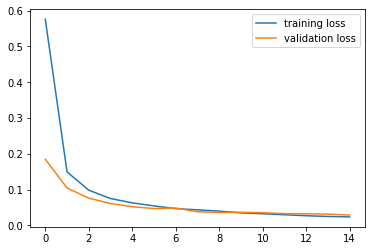

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
print(running_loss_history)
print(type(running_loss_history))

[tensor(84.4417, device='cuda:0'), tensor(95.5850, device='cuda:0'), tensor(97.0367, device='cuda:0'), tensor(97.7967, device='cuda:0'), tensor(98.1400, device='cuda:0'), tensor(98.3867, device='cuda:0'), tensor(98.5683, device='cuda:0'), tensor(98.7167, device='cuda:0'), tensor(98.7933, device='cuda:0'), tensor(98.9067, device='cuda:0'), tensor(99.0083, device='cuda:0'), tensor(99.0800, device='cuda:0'), tensor(99.2033, device='cuda:0'), tensor(99.2333, device='cuda:0'), tensor(99.2850, device='cuda:0')]
<class 'list'>


TypeError: ignored

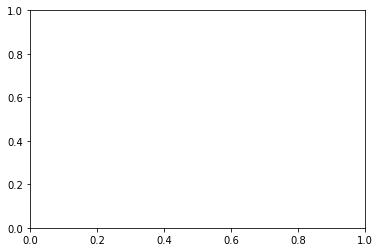

In [ ]:
print(running_corrects_history)
print(type(running_corrects_history))
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
import PIL.ImageOps

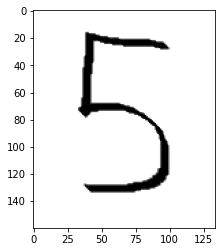

In [ ]:
import requests
from PIL import Image

url = '/content/drive/MyDrive/Colab Notebooks/55.png'
#response = requests.get(url, stream = True)
img = Image.open(url)
plt.imshow(img)

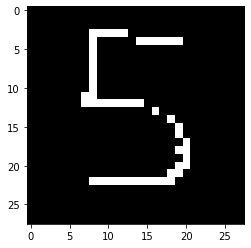

In [ ]:
img = PIL.ImageOps.invert(img)  # we use Image operations from PIL to invert(i.e. make white black and vice versa)
img = img.convert('1') # we convert from RGB to Gray
img = transform(img) # Apply the transform funct we defined earlier to make our downloaded img same as what we trained on
plt.imshow(im_convert(img))

In [ ]:
images = img.to(device)  # As our model is in the device
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


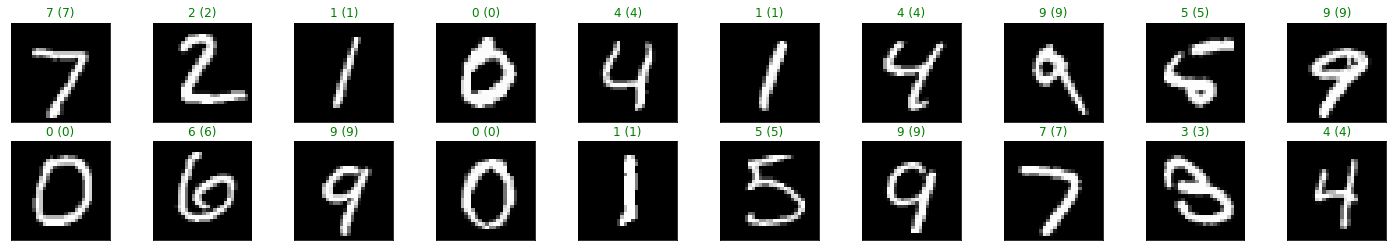

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.__next__()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

In [ ]:
torch.save(model.state_dict(), 'mnist_pytorch.pt')